In [1]:
%load_ext autoreload
%autoreload 2

# get project dir
# import standard libs
from IPython.display import display
from IPython.core.debugger import set_trace as bp
from pathlib import PurePath, Path
import sys
import time
from collections import OrderedDict as od
import re
import os
import json

pp = PurePath(Path.cwd()).parts[:]
pdir = PurePath(*pp)
data_script_dir = pdir / 'src' / 'data'
bars_script_dir = pdir / 'src' / 'features'
sys.path.append(data_script_dir.as_posix())
sys.path.append(bars_script_dir.as_posix())
viz_dir = pdir / 'reports' / 'figures'
data_dir = pdir / 'data'

# import python scientific stack
import pandas as pd
pd.set_option('display.max_rows', 100)
from dask import dataframe as dd
from dask.diagnostics import ProgressBar
from multiprocessing import cpu_count
pbar = ProgressBar()
pbar.register()
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from numba import jit
import math

# import visual tools
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns

plt.style.use('seaborn-talk')
plt.style.use('bmh')
#plt.rcParams['font.family'] = 'DejaVu Sans Mono'
plt.rcParams['font.size'] = 9.5
plt.rcParams['font.weight'] = 'medium'
plt.rcParams['figure.figsize'] = 10,7
blue, green, red, purple, gold, teal = sns.color_palette('colorblind', 6)

# import util libs
# from tqdm import tqdm, tqdm_notebook
import warnings
warnings.filterwarnings("ignore")
from utils import *
from bars import *
from labelling import *
from mpEngine import *
from sampleWeights import *
from ffd import *

RANDOM_STATE = 777


## [5.1] Generate a time series from an IID Gaussian random process. This is a memory-less, stationary series:

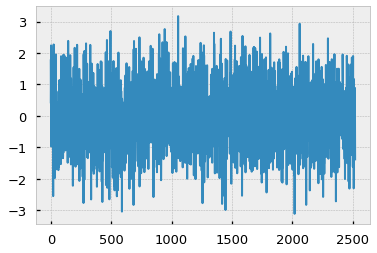

In [2]:
np.random.seed(0)

N = 252 * 10
s = pd.Series(np.random.randn(N)) # returna sample from the gaussian distribution
s.plot()

### a) Compute the ADF statistics on this series. What is the p-value?

In [3]:
res = sm.tsa.stattools.adfuller(s)
print('ADF stat: ',res[0],' p-value: ',res[1])

ADF stat:  -50.803321802760166  p-value:  0.0


### b) Compute the cumulative sum of the observations. This is a non-stationary series without memory

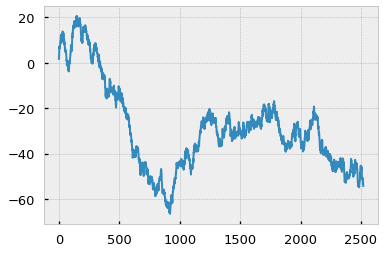

In [4]:
cmsm = pd.Series(s).cumsum()
cmsm.plot()

#### i) What is the order of integration of this cumulative series?

In [5]:
orders = [0,1,2,3,4]
p_val = lambda s: sm.tsa.stattools.adfuller(s)[1]

for o in orders:
    diff_ = np.diff(cmsm, o)
    print('=' * 27) 
    print(f'order: {o}, pval:{p_val(diff_)}')

order: 0, pval:0.5704444806659957
order: 1, pval:0.0
order: 2, pval:7.347529850655246e-30
order: 3, pval:0.0
order: 4, pval:0.0


In statistics, the order of integration, denoted I(d), of a time series is a summary statistic, which reports the minimum number of differences required to obtain a covariance-stationary series.

In this example, the order of integration is 1

#### ii) Compute the ADF stat on this series, What is the p-value?

In [6]:
print("The p-value of the cumulative series: ", p_val(cmsm))

The p-value of the cumulative series:  0.5704444806659957


### c) Differentiate the series twice. What is the p-value of this over-differentiated series?

In [7]:
diff_ = np.diff(s,2)
cum_diff_ = np.diff(cmsm, 2)
print("p-value of the original series: ", p_val(diff_), "p-value of the cum.series: ", p_val(cum_diff_))

p-value of the original series:  0.0 p-value of the cum.series:  7.347529850655246e-30


## [5.2] Generate a time series that follows a sinusoidal function. This is a stationary series with memory

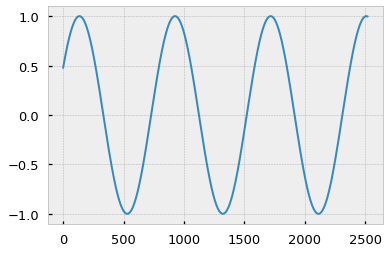

In [8]:
np.random.seed(0)
rand = np.random.random(N)
idx = np.linspace(0, 10, N)
s = pd.Series(1 * np.sin(2.* idx + .5))
s.plot()

### a) Compute the ADF stat on this series. What is the p-value?

In [9]:
res = sm.tsa.stattools.adfuller(s)
print('ADF stat: ',res[0],' p-value: ',res[1])

ADF stat:  -8053074074508.672  p-value:  0.0


### b) Shift every observation by the same positive value. Compute the cumulative sum of the observations. This is a non-stationary series with memory.

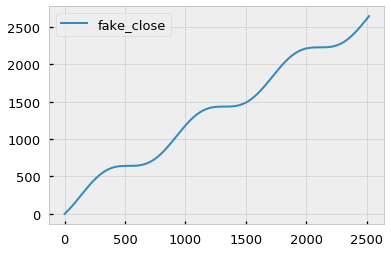

In [10]:
s_ = (s+1).cumsum().rename('fake_close').to_frame()
s_.plot()

#### i) Compute the ADF Statistics on this series. What is the p-value

In [11]:
res = sm.tsa.stattools.adfuller(s_['fake_close'])
print('ADF stat: ',res[0],' p-value: ',res[1])

ADF stat:  -0.09055556893818328  p-value:  0.9503711480907152


#### ii) Apply an expanding facdiff, with $\tau = 1E-2$. For what minimum $d$ value do you get  a p-value below 5%

In [12]:
cols = ['adfStat','pVal','lags','nObs','95% conf']#,'corr']
out = pd.DataFrame(columns=cols)
for d in np.linspace(0,0.4,40):
    df0 = fracDiff(s_,d)
    df0 = sm.tsa.stattools.adfuller(df0['fake_close'],maxlag=1,regression='c',autolag=None)
    out.loc[d]=list(df0[:4])+[df0[4]['5%']]



,adfStat,pVal,lags,nObs,95% conf
0.000000,2.833609,1.000000e+00,1.0,2517.0,-2.862689
0.010256,3.823719,1.000000e+00,1.0,1715.0,-2.863227
0.020513,-8.815686,1.937221e-14,1.0,1224.0,-2.863904
0.030769,-3.358019,1.247600e-02,1.0,1009.0,-2.864409
0.041026,6.753537,1.000000e+00,1.0,897.0,-2.864768
0.051282,11.535198,1.000000e+00,1.0,832.0,-2.865020
0.061538,12.725323,1.000000e+00,1.0,794.0,-2.865187
0.071795,12.177383,1.000000e+00,1.0,772.0,-2.865291
0.082051,11.004925,1.000000e+00,1.0,762.0,-2.865340
0.092308,9.741210,1.000000e+00,1.0,759.0,-2.865355


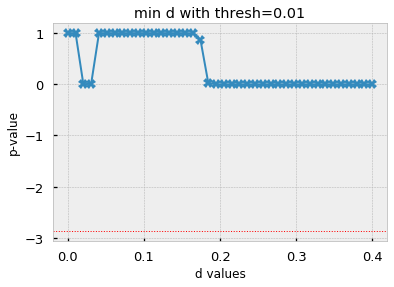

In [13]:
f,ax=plt.subplots()
out['pVal'].plot(ax=ax, marker='X')
ax.axhline(out['95% conf'].mean(),lw=1,color='r',ls='dotted')
ax.set_title('min d with thresh=0.01')
ax.set_xlabel('d values')
ax.set_ylabel('p-value');
display(out)

#### iii) Apply FFD with $\tau = 1E-5$. For what minimum $d$ value do you get a p-value below $5\%$

In [14]:
#cols = ['adfStat','pVal','lags','nObs','95% conf']#,'corr']
#out = pd.DataFrame(columns=cols)
#for d in np.linspace(0,0.4,40):
#    try:
#        df0 = fracDiff_FFD(s_,d,thres=1e-5)
#        df0 = sm.tsa.stattools.adfuller(df0['fake_close'],maxlag=1,regression='c',autolag=None)
#        out.loc[d]=list(df0[:4])+[df0[4]['5%']]
#    except Exception as e:
#        print(f'd: {d}, error: {e}')
#        continue

#f,ax=plt.subplots()
#out['pVal'].plot(ax=ax, marker='X')
#ax.axhline(out['95% conf'].mean(),lw=1,color='r',ls='dotted')
#ax.set_title('min d with thresh=0.0001')
#ax.set_xlabel('d values')
#ax.set_ylabel('p-value');
#display(out)

## [5.3] Take the series from exercise 2.b:

### (a) Fit the series to a sine function. What is the R-squared?

In [15]:

## fitting function taken from stackoverflow## fitti 
##   https://stackoverflow.com/questions/16716302/how-do-i-fit-a-sine-curve-to-my-data-with-pylab-and-numpy#16716964
#import numpy, scipy.optimize

#def fit_sin(tt, yy):
#    '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
#    tt = numpy.array(tt)
#    yy = numpy.array(yy)
#    ff = numpy.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
#    Fyy = abs(numpy.fft.fft(yy))
#    guess_freq = abs(ff[numpy.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
#    guess_amp = numpy.std(yy) * 2.**0.5
#    guess_offset = numpy.mean(yy)
#    guess = numpy.array([guess_amp, 2.*numpy.pi*guess_freq, 0., guess_offset])

#    def sinfunc(t, A, w, p, c):  return A * numpy.sin(w*t + p) + c
#    popt, pcov = scipy.optimize.curve_fit(sinfunc, tt, yy, p0=guess)
#    A, w, p, c = popt
#    f = w/(2.*numpy.pi)
#    fitfunc = lambda t: A * numpy.sin(w*t + p) + c
#    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": numpy.max(pcov), "rawres": (guess,popt,pcov)}

In [16]:
#res = fit_sin(s_.index.values, s_.values.ravel())
#res

In [17]:
#xx = s_.index.values
#yy = s_.values.ravel()

#plt.plot(xx, yy, "-k", label="y", linewidth=2)
##plt.plot(tt, yynoise, "ok", label="y with noise")
#plt.plot(xx, res["fitfunc"](xx), "r-", label="y fit curve", linewidth=2)
#plt.legend(loc="best")
#plt.show()

In [18]:
#slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(yy, res["fitfunc"](xx))
#r_value**2

### (b) Apply FFD$(d=1)$. Fit the series to a sine function. What is the R-squared?

In [19]:
#cols = ['adfStat','pVal','lags','nObs','95% conf']#,'corr']
#out = pd.DataFrame(columns=cols)
##df1 = fracDiff_FFD(s_,d=1)
#df1 = sm.tsa.stattools.adfuller(df0['fake_close'],maxlag=1,regression='c',autolag=None)
#out.loc[d]=list(df0[:4])+[df0[4]['5%']]
#df1.plot()

In [20]:
#xx = df1.index.values
#yy = df1.values.ravel()

#res = fit_sin(xx, yy)
#slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(yy, res["fitfunc"](xx))
#r_value**2

## [5.4] Take dollar bar series on E-mini S&P 500 futures. Using the code in Snippet 5.3, for some d in [0,2], compute fracDiff_FFD(fracDiff_FFD(series,d). What do you get? Why?

In [21]:
def dask_resample(ser, freq='L'):
    dds = dd.from_pandas(ser, chunksize=len(ser)//100)
    tdf = (dds
           .resample(freq)
           .mean()
           .dropna()
          ).compute()
    return tdf

infp=PurePath(data_dir/'processed'/'clean_IVE_fut_prices.parq')
df = pd.read_parquet(infp)
df = df.assign(dates = df.index)
#dv_rs = dask_resample(df, '1s')
#cprint(dv_rs)

dbars = dollar_bar_df(df, 'dv', 1_000_000)
dbars = dbars.drop(['dates'], axis = 1)
cprint(dbars)


-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                      price     bid     ask   size      v          dv
dates                                                                
2018-10-05 15:58:23  116.19  116.19  116.20   1354   1354   157321.26
2018-10-05 15:59:20  116.18  116.17  116.19    300    300    34854.00
2018-10-05 15:59:55  116.19  116.18  116.20    800    800    92952.00
2018-10-05 15:59:59  116.20  116.18  116.19   2000   2000   232400.00
2018-10-05 16:00:00  116.22  116.20  116.21  42884  42884  4983978.48
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 50766 entries, 2009-09-28 09:46:35 to 2018-10-05 16:00:00
Data columns (total 6 columns):
price    50766 non-null float64
bid      50766 non-null float64
ask      50766 non-null float64
size     50766 non-null int64
v       

Bug: [5.4] getWeights_FFD cannot recognize negative $d$

## [5.5] Take the dollar bar series on E-mini S&P 500 futures

### (a) Form a new series as a cumulative sum of log-prices

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                             price
dates                             
2018-10-05 15:58:23  225860.438048
2018-10-05 15:59:20  225865.193189
2018-10-05 15:59:55  225869.948416
2018-10-05 15:59:59  225874.703729
2018-10-05 16:00:00  225879.459214
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49996 entries, 2009-09-28 09:46:35 to 2018-10-05 16:00:00
Data columns (total 1 columns):
price    49996 non-null float64
dtypes: float64(1)
memory usage: 781.2 KB
None
-------------------------------------------------------------------------------



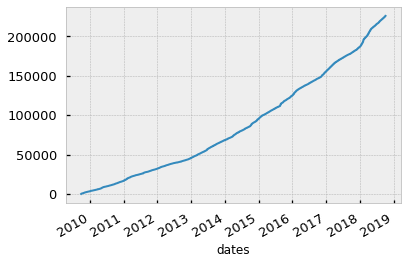

In [22]:
x = np.log(dbars.price).cumsum()
x = x[~x.index.duplicated()]
cprint(x)
x.plot()

### (b) Apply FFD, with $\tau = 1E-5$. Determine for what minimum $d \in [0,2]$ the new series is stationary 

In [23]:
def get_optimal_ffd(data, end, interval, t=1e-5):
    
    cols = ['adfStat','pVal','lags','nObs','95% conf']#,'corr']
    out = pd.DataFrame(columns=cols)
    
    for d in np.linspace(0,end,interval):
        try:
            
            dfx = fracDiff_FFD(data.to_frame(),d,thres=t)
            dfx = sm.tsa.stattools.adfuller(dfx['price'], maxlag=1,regression='c',autolag=None)
            out.loc[d]=list(dfx[:4])+[dfx[4]['5%']]
        except Exception as e:
            print(f'{d} error: {e}')
            
    return out

In [24]:
out = get_optimal_ffd(x, 2, 10)

In [25]:
out

,adfStat,pVal,lags,nObs,95% conf
0.000000,67.156387,1.000000,1.0,49994.0,-2.861598
0.222222,9.564391,1.000000,1.0,46871.0,-2.861602
0.444444,2.210799,0.998891,1.0,48802.0,-2.861599
0.666667,0.442605,0.983020,1.0,49560.0,-2.861598
0.888889,-0.487582,0.894417,1.0,49860.0,-2.861598
1.111111,-1.227327,0.661731,1.0,49910.0,-2.861598
1.333333,-1.514305,0.526423,1.0,49908.0,-2.861598
1.555556,-2.583721,0.096409,1.0,49928.0,-2.861598
1.777778,-4.831333,0.000047,1.0,49951.0,-2.861598
2.000000,-268.417713,0.000000,1.0,49992.0,-2.861598


In [26]:
min_ffd = out[out.pVal < 0.05].iloc[0].name
print("The min. D that makes the fracdiff stationary",min_ffd)

The min. D that makes the fracdiff stationary 1.7777777777777777


### (c) Compute the correlation of the fracdiff series to the original (untransformed) series

In [27]:
dfx2 = fracDiff_FFD(x.to_frame(),2)
cprint(dfx2)
joined = dfx2.join(x.rename('original'),how='left')
joined.corr()

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                        price
2018-10-05 15:58:23 -0.000430
2018-10-05 15:59:20 -0.000086
2018-10-05 15:59:55  0.000086
2018-10-05 15:59:59  0.000086
2018-10-05 16:00:00  0.000172
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49994 entries, 2009-09-28 09:55:26 to 2018-10-05 16:00:00
Data columns (total 1 columns):
price    49994 non-null float64
dtypes: float64(1)
memory usage: 781.2 KB
None
-------------------------------------------------------------------------------



,price,original
price,1.000000,-0.000013
original,-0.000013,1.000000


### (d) Apply Engel-Granger cointegration test on the original and fracdiff series. Are they cointegrated? Why?

In [28]:
coint_pval = sm.tsa.stattools.coint(joined.price, joined.original)[1]
print("p-value: ", coint_pval)
if coint_pval < 0.05:
    print("They are cointegrated")
else:
    print("They are not cointegrated")

p-value:  0.0
They are cointegrated


### (e) Apply a Jarque-Bera normality test on the fracdiff series.

In [29]:
jb_pval = stats.jarque_bera(dfx2)[1]
print("p-value: ", jb_pval)
if jb_pval < 0.05:
    print("The series is not normally distributed")
else:
    print("The series is normally distributed")

p-value:  0.0
The series is not normally distributed


## [5.6] Take the fracdiff series from exercise 5

### (a) Apply a CUSUM filter (Chapter 2), where h is twice the standard deviation of the series.

In [30]:
dfx2 = dfx2[~dfx2.index.duplicated()]
cprint(dfx2)
ffd_std = dfx2.std()[0]
ffd_std

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                        price
2018-10-05 15:58:23 -0.000430
2018-10-05 15:59:20 -0.000086
2018-10-05 15:59:55  0.000086
2018-10-05 15:59:59  0.000086
2018-10-05 16:00:00  0.000172
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49994 entries, 2009-09-28 09:55:26 to 2018-10-05 16:00:00
Data columns (total 1 columns):
price    49994 non-null float64
dtypes: float64(1)
memory usage: 781.2 KB
None
-------------------------------------------------------------------------------



0.9400002590332018

In [31]:
def getTEvents2(gRaw, h, symmetric = True, isReturn = False):
    """
    Symmetric CUSUM Filter
    Sample a bar t iff S_t >= h at which point S_t is reset
    Multiple events are not triggered by gRaw hovering around a threshold level
    It will require a full run of length h for gRaw to trigger an event
    
    Two arguments:
        gRaw: the raw time series we wish to filter (gRaw), e.g. return
        h: threshold
        
    Return:
        pd.DatatimeIndex.append(tEvents): 
    """
    tEvents, sPos, sNeg = [], 0, 0
    if isReturn:
        diff = gRaw
    else:
        diff = gRaw.diff()
    if symmetric:
        if np.shape(h) == ():

            for i in diff.index[1:]:
                tmp = diff.loc[i].mean()
                sPos, sNeg = max(0,sPos+tmp), min(0,sNeg+tmp)
                if sNeg < -h and tradableHour(i):
                    sNeg = 0; tEvents.append(i)
                elif sPos > h and tradableHour(i):
                    sPos = 0; tEvents.append(i)
        else:
            for i in diff.index[1:]:
                tmp = diff.loc[i].mean()
                sPos, sNeg = max(0,sPos+tmp), min(0,sNeg+tmp)
                if sNeg < -h[i] and tradableHour(i):
                    sNeg = 0; tEvents.append(i)
                elif sPos > h[i] and tradableHour(i):
                    sPos = 0; tEvents.append(i)
    else:
        if np.shape(h) == ():

            for i in diff.index[1:]:
                tmp = diff.loc[i].mean()
                sAbs = sAbs+tmp
                if sAbs > h and tradableHour(i):
                    sNeg = 0; tEvents.append(i)
                
        else:
            for i in diff.index[1:]:
                tmp = diff.loc[i].mean()
                sAbs = sAbs+tmp
                if sAbs > h[i] and tradableHour(i):
                    sNeg = 0; tEvents.append(i)
            
    return pd.DatetimeIndex(tEvents)

In [32]:
tEvents = getTEvents2(dfx2,h=ffd_std*2)
display(tEvents)

DatetimeIndex(['2009-11-03 11:20:59', '2009-11-03 11:21:01',
               '2009-11-03 11:22:04', '2009-12-03 13:13:31',
               '2009-12-03 14:24:15', '2009-12-03 14:50:50',
               '2009-12-04 09:54:02', '2009-12-04 10:18:41',
               '2010-04-22 12:23:34', '2010-04-22 12:33:19',
               ...
               '2018-09-21 09:55:07', '2018-09-25 14:23:14',
               '2018-09-25 14:34:53', '2018-09-25 14:53:26',
               '2018-10-02 11:39:06', '2018-10-02 11:49:10',
               '2018-10-02 12:12:54', '2018-10-04 13:44:24',
               '2018-10-04 13:54:45', '2018-10-04 14:01:44'],
              dtype='datetime64[ns]', length=1633, freq=None)

In [33]:
dbars_feat = dbars.price.loc[tEvents]
frac_diff_feat = dfx2.loc[tEvents]
ftMtx = (pd.DataFrame()
         .assign(dbars=dbars_feat,
                 frac_diff_feat=frac_diff_feat)
         .drop_duplicates().dropna())
cprint(ftMtx)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                        dbars  frac_diff_feat
dates                                        
2018-10-02 11:49:10  116.4980       -4.754773
2018-10-02 12:12:54  116.5699        0.000617
2018-10-04 13:44:24  116.1600        4.754977
2018-10-04 13:54:45  116.0337       -4.755023
2018-10-04 14:01:44  116.0100       -0.000204
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1675 entries, 2009-11-03 11:20:59 to 2018-10-04 14:01:44
Data columns (total 2 columns):
dbars             1675 non-null float64
frac_diff_feat    1675 non-null float64
dtypes: float64(2)
memory usage: 39.3 KB
None
-------------------------------------------------------------------------------



In [34]:
def getDailyVol2(close,span0=100):
    # daily vol reindexed to close
    df0=close.index.searchsorted(close.index-pd.Timedelta(days=1))
    #bp()
    df0=df0[df0>0]
    #bp()
    df0=(pd.Series(close.index[df0-1],
                   index=close.index[close.shape[0]-df0.shape[0]:]))
    #bp()
    try:
        df0=close.loc[df0.index]/close.loc[df0.values].values-1 # daily rets
    except Exception as e:
        print(e)
        print('adjusting shape of close.loc[df0.index]')
        cut = close.loc[df0.index].shape[0] - close.loc[df0.values].shape[0]
        # I dont't think it make sense
        df0=close.loc[df0.index].iloc[:-cut]/close.loc[df0.values].values-1
    df0=df0.ewm(span=span0).std().rename('dailyVol')
    return df0


ftMtx = ftMtx[~ftMtx.index.duplicated()]
dailyVol = getDailyVol2(ftMtx.dbars)
t1 = addVerticalBarrier(tEvents, ftMtx.dbars, hour=120)

ptsl = [1,1]
#ptsl = [daily]
target=dailyVol*2
# select minRet
minRet = 0.01
# get cpu count - 1
cpus = cpu_count() - 1
events = getEvents(ftMtx.dbars,tEvents,ptsl,target,minRet,cpus,t1=t1)
cprint(events)

2018-10-27 17:32:56.220751 100.0% applyPtSlOnT1 done after 0.01 minutes. Remaining 0.0 minutes.


-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                     t1      trgt
2018-10-02 11:49:10 NaT  0.020142
2018-10-02 12:12:54 NaT  0.020067
2018-10-04 13:44:24 NaT  0.019922
2018-10-04 13:54:45 NaT  0.019802
2018-10-04 14:01:44 NaT  0.019685
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1619 entries, 2010-05-03 14:16:41 to 2018-10-04 14:01:44
Data columns (total 2 columns):
t1      1613 non-null datetime64[ns]
trgt    1619 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 37.9 KB
None
-------------------------------------------------------------------------------



In [35]:
close=ftMtx.dbars
out = get_Concur_Uniqueness(close,events,cpus)

2018-10-27 17:32:56.704921 100.0% mpNumCoEvents done after 0.0 minutes. Remaining 0.0 minutes..
2018-10-27 17:32:56.990270 100.0% mpSampleTW done after 0.0 minutes. Remaining 0.0 minutes..
2018-10-27 17:32:57.436798 100.0% mpSampleW done after 0.0 minutes. Remaining 0.0 minutes..


In [36]:
labels = getBins(events, ftMtx.dbars)
clean_labels = dropLabels(labels)
cprint(clean_labels)

dropped label:  0.0 0.0012353304508956147
-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                          ret  bin
2018-10-02 11:39:06 -0.002536 -1.0
2018-10-02 11:49:10 -0.004189 -1.0
2018-10-02 12:12:54 -0.004803 -1.0
2018-10-04 13:44:24 -0.001291 -1.0
2018-10-04 13:54:45 -0.000204 -1.0
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1617 entries, 2010-05-03 14:16:41 to 2018-10-04 13:54:45
Data columns (total 2 columns):
ret    1617 non-null float64
bin    1617 non-null float64
dtypes: float64(2)
memory usage: 37.9 KB
None
-------------------------------------------------------------------------------



### (d) Fit a bagging classifier of decision trees where:

#### (i) The observed features are bootstrapped using the sequential method from chapter 4.
Note: must use multiprocessing of some kind as seqBootstrap is very slow

In [37]:
import numba as nb
@nb.njit
def func(arr,i):
    col = arr[i]
    mask = np.where(col>0)
    return np.mean(col[mask])

@nb.njit
def njit_getAvgUniqueness(indM):
    # Average uniqueness from indicator matrix
    c=indM.sum(axis=1).reshape(-1,1) # concurrency
    u=np.divide(indM,c) # uniqueness
    avgU = np.zeros(len(u.T)) # avg. uniqueness
    i = 0
    for i in range(len(u.T)):
        avgU[i] = func(u.T,i)
        i+=1
    return avgU

@nb.jit
def jit_seqBootstrap(indM,sLength=None):
    # Generate a sample via sequential bootstrap
    if sLength is None:sLength=indM.shape[1]
    phi=[]
    while len(phi)<sLength:
        avgU=pd.Series()
        for i in indM:
            indM_=indM[phi+[i]] # reduce indM
            avgU.loc[i]=njit_getAvgUniqueness(indM_.values)[-1]
        prob=avgU/avgU.sum() # draw prob
        phi+=[np.random.choice(indM.columns,p=prob)]
    return phi
#------------------------

def split_t1(t1, partitions):
    return np.array_split(t1, partitions)

def mp_func(indM):
    # jit funcs about 2x as fast
    phi = jit_seqBootstrap(indM)
    seqU = njit_getAvgUniqueness(indM[phi].values).mean()
    #phi = seqBootstrap(indM)
    #seqU= getAvgUniqueness(indM[phi])
    return seqU

def main_mp(t1, partitions=100, cpus=8):
    jobs = []
    splits = split_t1(t1,partitions=100)
    for part_t1 in splits:
        indM = getIndMatrix(part_t1.index, part_t1)
        job = {'func':mp_func,'indM':indM}
        jobs.append(job)
    if cpus==1: out= processJobs_(jobs)
    else: out= processJobs(jobs,numThreads=cpus)
    return pd.DataFrame(out)

In [38]:
seqUs = main_mp(t1)

2018-10-27 17:33:05.791147 100.0% mp_func done after 0.12 minutes. Remaining 0.0 minutes.


In [53]:
# get avg uniqueness for bootstrapping
avgU = seqUs.mean()[0]
avgU1 = out['tW'].mean()

### (ii) On each bootstrapped sample, sample weights are determined using the techniques from Chapter 4
Note: alternative implementations are welcome.

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, BaggingClassifier

In [41]:
def evaluate(X,y,clf):
    from sklearn import metrics
    # The random forest model by itself
    y_pred_rf = clf.predict_proba(X)[:, 1]
    y_pred = clf.predict(X)
    fpr_rf, tpr_rf, _ = metrics.roc_curve(y, y_pred_rf)
    print(metrics.classification_report(y, y_pred))

    plt.figure(figsize=(9,6))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_rf, tpr_rf, label='clf')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()

In [42]:
trgt = clean_labels.bin
trgt

2010-05-03 14:16:41   -1.0
2010-05-03 14:27:25   -1.0
2010-05-03 14:57:03   -1.0
2010-06-22 10:00:00   -1.0
2010-06-22 10:19:06   -1.0
2010-06-22 11:20:49   -1.0
2010-07-06 15:15:51    1.0
2010-07-06 15:36:44    1.0
2010-07-07 10:16:53    1.0
2010-08-02 15:47:58   -1.0
2010-08-03 10:03:41   -1.0
2010-08-03 10:48:54   -1.0
2010-08-04 12:59:55   -1.0
2010-08-04 14:50:03   -1.0
2010-08-04 14:56:36   -1.0
2010-08-31 15:20:53    1.0
2010-08-31 15:35:45    1.0
2010-08-31 15:35:46    1.0
2010-09-01 11:33:42    1.0
2010-09-01 11:33:43    1.0
2010-09-01 11:37:51    1.0
2010-09-07 12:44:44    1.0
2010-09-07 13:56:46    1.0
2010-09-07 14:54:49    1.0
2010-09-08 09:45:53    1.0
2010-10-05 10:24:21    1.0
2010-10-05 10:24:23    1.0
2010-10-05 10:24:25    1.0
2010-11-02 11:30:52    1.0
2010-11-02 12:47:47    1.0
2010-11-02 13:48:10    1.0
2010-11-08 10:03:02    1.0
2010-11-08 10:35:44    1.0
2010-11-08 11:02:11    1.0
2010-11-11 12:33:18    1.0
2010-11-11 12:59:16    1.0
2010-11-11 13:36:26    1.0
2

In [43]:

# model data# model  
data = ftMtx.join(out,how='left').join(trgt,how='left').dropna()
data = data.drop(['t1'],axis = 1)
X = data.iloc[:,:-1].values
y = data.iloc[:,-1].values.reshape(-1,1)
cprint(data)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                        dbars  frac_diff_feat        tW         w  bin
dates                                                                 
2018-10-02 11:39:06  116.3050        4.756302  0.265476  0.504378 -1.0
2018-10-02 11:49:10  116.4980       -4.754773  0.290000  0.038143 -1.0
2018-10-02 12:12:54  116.5699        0.000617  0.237500  0.362243 -1.0
2018-10-04 13:44:24  116.1600        4.754977  0.205556  0.442645 -1.0
2018-10-04 13:54:45  116.0337       -4.755023  0.183333  0.098369 -1.0
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1617 entries, 2010-05-03 14:16:41 to 2018-10-04 13:54:45
Data columns (total 5 columns):
dbars             1617 non-null float64
frac_diff_feat    1617 non-null float64
tW                1617 non-null float64
w       

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)

In [54]:
base_clf = DecisionTreeClassifier(criterion='entropy',max_features='auto',
                                  class_weight='balanced')
bc = BaggingClassifier(base_estimator=base_clf,n_estimators=1000,
                       max_samples=avgU1,max_features=1.,random_state=RANDOM_STATE)

In [55]:
fit  =  bc.fit(X_train, y_train)

              precision    recall  f1-score   support

        -1.0       0.57      0.25      0.35       184
         1.0       0.66      0.89      0.76       302

   micro avg       0.65      0.65      0.65       486
   macro avg       0.62      0.57      0.55       486
weighted avg       0.63      0.65      0.60       486



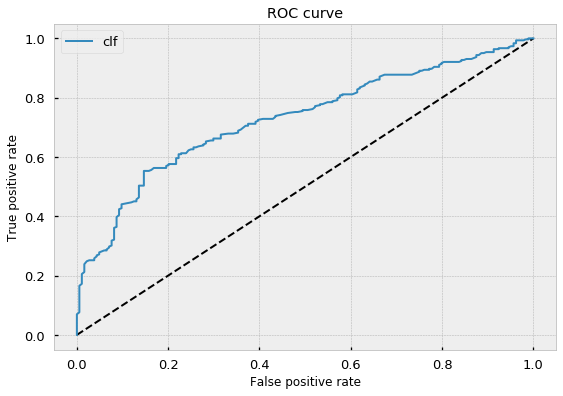

In [56]:
evaluate(X_test,y_test,fit)

              precision    recall  f1-score   support

        -1.0       0.59      0.28      0.38       184
         1.0       0.67      0.88      0.76       302

   micro avg       0.65      0.65      0.65       486
   macro avg       0.63      0.58      0.57       486
weighted avg       0.64      0.65      0.62       486



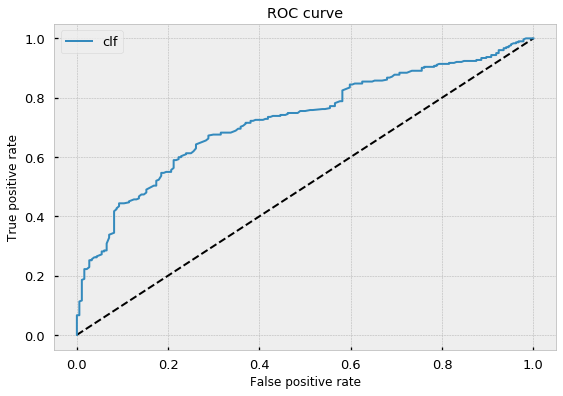

In [57]:

rf_clf  =  RandomForestClassifier(n_estimators=1,
                                class_weight='balanced_subsample',
                                criterion='entropy', 
                                bootstrap=False)
bc_rf = BaggingClassifier(base_estimator=rf_clf, n_estimators=1000,
                          max_samples=avgU1, max_features=1., 
                          random_state=RANDOM_STATE)

fit = bc_rf.fit(X_train,y_train)
evaluate(X_test,y_test,fit)

              precision    recall  f1-score   support

        -1.0       0.50      0.20      0.28       184
         1.0       0.64      0.88      0.74       302

   micro avg       0.62      0.62      0.62       486
   macro avg       0.57      0.54      0.51       486
weighted avg       0.59      0.62      0.57       486



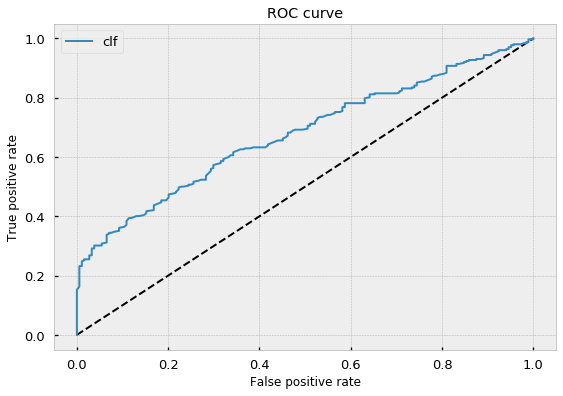

In [60]:
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.fit_transform(X_test)


rf_clf  =  RandomForestClassifier(n_estimators=1,
                                class_weight='balanced_subsample',
                                criterion='entropy', 
                                bootstrap=False)
bc_rf = BaggingClassifier(base_estimator=rf_clf, n_estimators=1000,
                          max_samples=avgU1, max_features=1., 
                          random_state=RANDOM_STATE)
fit = bc_rf.fit(X_train_std,y_train)
evaluate(X_test_std, y_test, fit)

              precision    recall  f1-score   support

        -1.0       0.49      0.22      0.30       184
         1.0       0.64      0.86      0.74       302

   micro avg       0.62      0.62      0.62       486
   macro avg       0.57      0.54      0.52       486
weighted avg       0.58      0.62      0.57       486



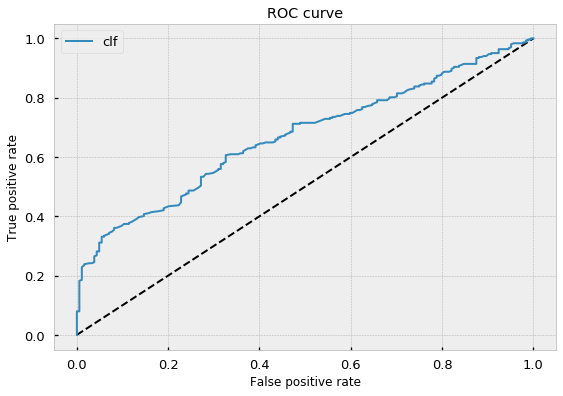

In [61]:
base_clf = DecisionTreeClassifier(criterion='entropy',max_features='auto',
                                  class_weight='balanced')
bc = BaggingClassifier(base_estimator=base_clf,n_estimators=1000,
                       max_samples=avgU1,max_features=1.,random_state=RANDOM_STATE)
fit  =  bc.fit(X_train_std, y_train)
evaluate(X_test_std, y_test, fit)